In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics

from interpret import show
from interpret.glassbox import ExplainableBoostingClassifier

# from interpret import set_visualize_provider
# from interpret.provider import InlineProvider
# set_visualize_provider(InlineProvider())

In [2]:
# import data
df = pd.read_csv("./data/CEE_DATA.csv", quotechar="'")

X = df[
    [
        "Gender",
        "Caste",
        "coaching",
        "time",
        "Class_ten_education",
        "twelve_education",
        "medium",
        "Class_X_Percentage",
        "Class_XII_Percentage",
        "Father_occupation",
        "Mother_occupation",
    ]
]
Y = df["Performance"]

In [3]:
# split data
seed = 1
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.3, random_state=seed
)
print("Train Size Instances: ", X_train.shape[0])
print("Test Size Instances:", X_test.shape[0])

Train Size Instances:  466
Test Size Instances: 200


In [4]:
ohe = OneHotEncoder(sparse=False)
Xoded = pd.DataFrame(ohe.fit_transform(X),columns=ohe.get_feature_names(['Gender', 'Caste', 'coaching', 'time', 'Class_ten_education',
       'twelve_education', 'medium', 'Class_X_Percentage',
       'Class_XII_Percentage', 'Father_occupation', 'Mother_occupation']))
X_train_enc, X_test_enc, Y_train_enc, Y_test_enc = train_test_split(
    Xoded, Y, test_size=0.3, random_state=seed
)
print("Train Size Instances: ", X_train_enc.shape[0])
print("Test Size Instances:", X_test_enc.shape[0])

Train Size Instances:  466
Test Size Instances: 200


## EBM

In [5]:
# https://interpret.ml/docs/ebm.html?highlight=multiclass#

ebm = ExplainableBoostingClassifier(random_state=seed)
ebm.fit(X_train_enc, Y_train_enc)

# global explanations
ebm_global = ebm.explain_global()
show(ebm_global)

C:\Anaconda\anaconda3\envs\RnD\lib\site-packages\interpret\glassbox\ebm\ebm.py:922: UserWarning: Multiclass is still experimental. Subject to change per release.
  warn("Multiclass is still experimental. Subject to change per release.")
C:\Anaconda\anaconda3\envs\RnD\lib\site-packages\interpret\glassbox\ebm\ebm.py:925: UserWarning: Detected multiclass problem: forcing interactions to 0
  warn("Detected multiclass problem: forcing interactions to 0")
C:\Anaconda\anaconda3\envs\RnD\lib\site-packages\interpret\visual\udash.py:5: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
C:\Anaconda\anaconda3\envs\RnD\lib\site-packages\interpret\visual\udash.py:6: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc
C:\Anaconda\anaconda3\envs\Rn

<!-- http://127.0.0.1:7001/3056797110224/ -->

In [6]:
ebm_global.data(-1)

{'overall': {'type': 'univariate',
  'names': ['Gender_female',
   'Gender_male',
   'Caste_General',
   'Caste_OBC',
   'Caste_SC',
   'Caste_ST',
   'coaching_NO',
   'coaching_OA',
   'coaching_WA',
   'time_FIVE',
   'time_FOUR',
   'time_ONE',
   'time_SEVEN',
   'time_THREE',
   'time_TWO',
   'Class_ten_education_CBSE',
   'Class_ten_education_OTHERS',
   'Class_ten_education_SEBA',
   'twelve_education_AHSEC',
   'twelve_education_CBSE',
   'twelve_education_OTHERS',
   'medium_ASSAMESE',
   'medium_ENGLISH',
   'medium_OTHERS',
   'Class_X_Percentage_Average',
   'Class_X_Percentage_Excellent',
   'Class_X_Percentage_Good',
   'Class_X_Percentage_Vg',
   'Class_XII_Percentage_Average',
   'Class_XII_Percentage_Excellent',
   'Class_XII_Percentage_Good',
   'Class_XII_Percentage_Vg',
   'Father_occupation_BANK_OFFICIAL',
   'Father_occupation_BUSINESS',
   'Father_occupation_COLLEGE_TEACHER',
   'Father_occupation_CULTIVATOR',
   'Father_occupation_DOCTOR',
   'Father_occupatio

In [7]:
ebm.get_params()

{'binning': 'quantile',
 'early_stopping_rounds': 50,
 'early_stopping_tolerance': 0.0001,
 'feature_names': ['Gender_female',
  'Gender_male',
  'Caste_General',
  'Caste_OBC',
  'Caste_SC',
  'Caste_ST',
  'coaching_NO',
  'coaching_OA',
  'coaching_WA',
  'time_FIVE',
  'time_FOUR',
  'time_ONE',
  'time_SEVEN',
  'time_THREE',
  'time_TWO',
  'Class_ten_education_CBSE',
  'Class_ten_education_OTHERS',
  'Class_ten_education_SEBA',
  'twelve_education_AHSEC',
  'twelve_education_CBSE',
  'twelve_education_OTHERS',
  'medium_ASSAMESE',
  'medium_ENGLISH',
  'medium_OTHERS',
  'Class_X_Percentage_Average',
  'Class_X_Percentage_Excellent',
  'Class_X_Percentage_Good',
  'Class_X_Percentage_Vg',
  'Class_XII_Percentage_Average',
  'Class_XII_Percentage_Excellent',
  'Class_XII_Percentage_Good',
  'Class_XII_Percentage_Vg',
  'Father_occupation_BANK_OFFICIAL',
  'Father_occupation_BUSINESS',
  'Father_occupation_COLLEGE_TEACHER',
  'Father_occupation_CULTIVATOR',
  'Father_occupation_DO

In [8]:
# local explanations
ebm_local = ebm.explain_local(X_test_enc[:5], Y_train_enc[:5])
show(ebm_local)

<!-- http://127.0.0.1:7001/3056811455584/ -->

Accuracy:  0.47
Precision:  0.46063013563013566
Recall:  0.4604519345980447
F1 score:  0.44511650082918736


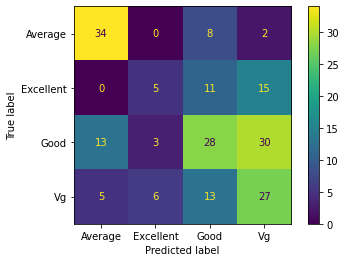

In [9]:
Y_pred = ebm.predict(X_test_enc)
print("Accuracy: ", metrics.accuracy_score(Y_test, Y_pred))
print("Precision: ", metrics.precision_score(Y_test, Y_pred, average="macro"))
print("Recall: ", metrics.recall_score(Y_test, Y_pred, average="macro"))
print("F1 score: ", metrics.f1_score(Y_test, Y_pred, average="macro"))
cm = metrics.confusion_matrix(Y_test, Y_pred, labels=ebm.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ebm.classes_)
disp.plot()
plt.show()

## Linear Model

In [10]:
# https://interpret.ml/docs/lr.html

from interpret.glassbox import LogisticRegression

lr = LogisticRegression(random_state=seed)
lr.fit(X_train_enc, Y_train_enc)

lr_global = lr.explain_global()
show(lr_global)

C:\Anaconda\anaconda3\envs\RnD\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



<!-- http://127.0.0.1:7001/3056819400608/ -->

In [11]:
# seems this one doesn't support strings for y labels
# lr_local = lr.explain_local(X_test_enc[:5], Y_test_enc[:5])
# show(lr_local)

In [12]:
def show_metrics(model, X_test, Y_test):
    Y_pred = model.predict(X_test)
    print("Accuracy: ", metrics.accuracy_score(Y_test, Y_pred))
    print("Precision: ", metrics.precision_score(Y_test, Y_pred, average="macro"))
    print("Recall: ", metrics.recall_score(Y_test, Y_pred, average="macro"))
    print("F1 score: ", metrics.f1_score(Y_test, Y_pred, average="macro"))
    cm = metrics.confusion_matrix(Y_test, Y_pred, labels=model._model().classes_)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model._model().classes_)
    disp.plot()
    plt.show()

Accuracy:  0.49
Precision:  0.484970050441362
Recall:  0.48095502566565185
F1 score:  0.4683762666431013


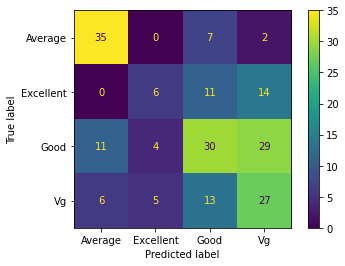

In [13]:
show_metrics(lr, X_test_enc, Y_test_enc)

## Decision tree

In [14]:
from interpret.glassbox import ClassificationTree

dt = ClassificationTree(random_state=seed)
dt.fit(X_train_enc, Y_train_enc)

dt_global = dt.explain_global()
show(dt_global)

<!-- http://127.0.0.1:7001/3056796904272/ -->

In [15]:
# seems this one doesn't support strings for y labels
# dt_local = dt.explain_local(X_test_enc[:5], Y_test_enc[:5])
# show(dt_local)

In [ ]:
show_metrics(dt, X_test_enc, Y_test_enc)

Accuracy:  0.415
Precision:  0.31522727272727274
Recall:  0.4523101029268012
F1 score:  0.35457516339869277


C:\Anaconda\anaconda3\envs\RnD\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



## Descision Rule

In [ ]:
from interpret.glassbox import DecisionListClassifier

dl = DecisionListClassifier(random_state=seed)
dl.fit(X_train_enc, Y_train_enc)

dl_global = dl.explain_global()
show(dl_global)

In [ ]:
# seems this one doesn't support strings for y labels
# dl_local = dl.explain_local(X_test_enc[:5], Y_test_enc[:5])
# show(dl_local)

In [ ]:
Y_pred = dl.predict(X_test_enc)
print("Accuracy: ", metrics.accuracy_score(Y_test, Y_pred))
print("Precision: ", metrics.precision_score(Y_test, Y_pred, average="macro"))
print("Recall: ", metrics.recall_score(Y_test, Y_pred, average="macro"))
print("F1 score: ", metrics.f1_score(Y_test, Y_pred, average="macro"))
cm = metrics.confusion_matrix(Y_test, Y_pred, labels=dl.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dl.classes_)
disp.plot()
plt.show()